In [1]:
from glob import glob

from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np

In [2]:
region = 'itc'

data = {'itc': {'fac': [], 'bod': [], 'art': [], 'nat': [], 'fac0': [], 'bod0': [], 'art0': [], 'nat0': []},
        'pfc': {'fac': [], 'bod': [], 'art': [], 'nat': [], 'fac0': [], 'bod0': [], 'art0': [], 'nat0': []}}
basedir = 'G:/Results/SUA/dec/c-ovr-final/time-time'

for fname in glob(f'{basedir}\c-ovr-r-*-dpr.pickle'):
    with open(fname, 'rb') as handler:
        dpr = pickle.load(handler)

    for region in ['itc', 'pfc']:
        for category in ['fac', 'bod', 'art', 'nat']:
            data[region][category].append(np.mean(dpr[region][category], 0))

for fname in glob(f'{basedir}\c-ovr-p-*-dpr.pickle'):
    with open(fname, 'rb') as handler:
        dpr = pickle.load(handler)

    for region in ['itc', 'pfc']:
        for category in ['fac', 'bod', 'art', 'nat']:
            data[region][category+"0"].append(np.mean(dpr[region][category], 0))

for region in ['itc', 'pfc']:
    for key in data[region].keys():
        data[region][key] = np.array(data[region][key])

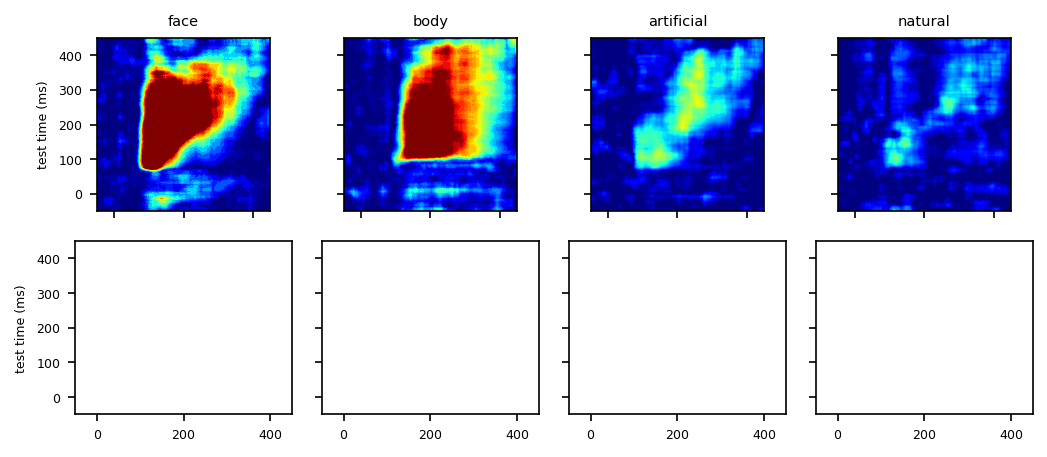

In [3]:
from skimage.morphology import erosion, dilation
# kernel = np.ones((2, 2), np.uint8)
kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
# kernel = np.array([[0, 1, 1, 0], [1, 1, 1, 1], [1, 1, 1, 1], [0, 1, 1, 0]])

cl = 95

cm = 1 / 2.54
tim = np.arange(-200, 675, step=5) + 12.5
fig, axs = plt.subplots(2, 4, figsize=(18 * cm, 8 * cm), dpi=150, sharey=True, sharex=True, squeeze=False)
axs = axs.flatten()

tim = np.arange(-200, 675, step=5) + 12.5

for ax, category, title in zip(axs[:4], ['fac', 'bod', 'art', 'nat'], ['face', 'body', 'artificial', 'natural']):
    Z0 = data['itc'][category+"0"]
    Z = data['itc'][category].mean(0) - Z0.mean(0)
    
    sig = Z > np.percentile(Z0, q=cl, axis=0)
    sig = erosion(sig, kernel)
    sig = dilation(sig, kernel)

    im = ax.contourf(tim, tim, Z, levels=50, cmap='jet', vmin=0, vmax=.1)
    # im = ax.contourf(tim, tim, sig, levels=50, cmap='jet', vmin=0, vmax=.1, alpha=0.1)

    # im = ax.contourf(tim, tim, Z, levels=50, cmap='jet', vmin=0)
    ax.axis('square')
    ax.set_title(title, fontsize=7)

# for ax, category in zip(axs[4:], ['fac', 'bod', 'art', 'nat']):
#     Z0 = data['pfc'][category+"0"]
#     Z = data['pfc'][category].mean(0) - Z0.mean(0)
    
#     sig = Z > np.percentile(Z0, q=cl, axis=0)
#     sig = erosion(sig, kernel)
#     sig = dilation(sig, kernel)

#     im = ax.contourf(tim, tim, Z, levels=50, cmap='jet', vmin=0, vmax=.1)
#     im = ax.contourf(tim, tim, sig, levels=50, cmap='jet', vmin=0, vmax=.1, alpha=.1)

#     ax.axis('square')
#     ax.set_xlabel("train time (ms)", fontsize=6)

for ax in axs[[0, 4]]:
    ax.set_ylabel("test time (ms)", fontsize=6)
    ax.set_xlim(-50, 450)
    ax.set_ylim(-50, 450)

for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=6)

# plt.colorbar(im, ax=axs.ravel().tolist())
# fig.tight_layout()
# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
# fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()

# plt.savefig('dcs-time-time.pdf')

In [134]:
Z0 = data['itc']['art0']
Z  = data['itc']['art']

n = Z0.shape[0]
T = (Z - Z0.mean(0)) / (Z0.std(0))
# T = (Z - Z0.mean(0)) / (Z0.std(0) / np.sqrt(n))

from scipy import stats
import statsmodels as sm

pvals = stats.t.sf(np.abs(T), n-1)*2
reject, pval_cor, _, _ = sm.stats.multitest.multipletests(pvals.flatten(), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)



# plt.colorbar()

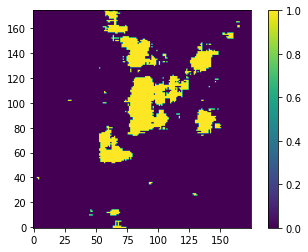

In [135]:
plt.imshow(pval_cor.reshape(pvals.squeeze().shape) < 0.05)
plt.colorbar()
plt.gca().invert_yaxis()

In [97]:
from mne.stats import permutation_cluster_1samp_test

alpha = 0.01
n_samples = Z.shape[0]

threshold = stats.distributions.t.ppf(1 - alpha, n_samples - 1)

t_clust, clusters, p_values, H0 = permutation_cluster_1samp_test(
    Z - Z0, n_jobs=1, threshold=threshold,
    n_permutations=1000)

stat_fun(H1): min=-8.672023 max=36.639210
Running initial clustering
Found 628 clusters
Permuting 999 times...


100%|██████████|  : 999/999 [00:15<00:00,   64.82it/s]

Computing cluster p-values


Done.


(-187.5, 682.5, -187.5, 682.5)

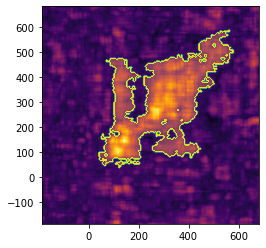

In [99]:
ts, ps, mccs = [], [], []
p_clust = np.ones((175, 175))
for cl, p in zip(clusters, p_values):
    p_clust[cl] = p
ts.append(t_clust)
ps.append(p_clust)
mccs.append(True)

p = -np.log10(np.reshape(np.maximum(ps, 1e-5), (175, 175)))
plt.contourf(tim, tim, Z-Z0.mean(0), levels=200, cmap='inferno')
plt.contourf(tim, tim, p > 2.99, levels=200, alpha=.2)
plt.axis('square')
# plt.colorbar()

In [103]:
threshold_tfce = dict(start=0, step=0.2)
t_tfce, _, p_tfce, H0 = permutation_cluster_1samp_test(
    Z - Z0, n_jobs=1, threshold=threshold_tfce,
    n_permutations=200)
# ts.append(t_tfce)
# ps.append(p_tfce)
# mccs.append(True)
# plot_t_p(ts[-1], ps[-1], titles[-1], mccs[-1])

stat_fun(H1): min=-8.672023 max=36.639210
Running initial clustering
Using 184 thresholds from 0.00 to 36.60 for TFCE computation (h_power=2.00, e_power=0.50)
Found 30625 clusters
Permuting 199 times...


100%|██████████|  : 199/199 [11:08<00:00,    3.36s/it]

Computing cluster p-values


Done.


(-187.5, 682.5, -187.5, 682.5)

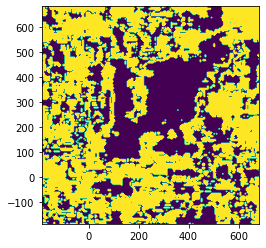

In [118]:
ts, ps, mccs = [], [], []
p_clust = np.ones((175, 175))
for cl, p in zip(clusters, p_tfce):
    p_clust[cl] = p
ts.append(t_clust)
ps.append(p_clust)
mccs.append(True)

p = -np.log10(np.reshape(np.maximum(ps, 1e-5), (175, 175)))
# plt.contourf(tim, tim, Z-Z0.mean(0), levels=200, cmap='inferno')
plt.contourf(tim, tim, np.array(np.squeeze(ps)) > .99, levels=200, alpha=1)
plt.axis('square')
# plt.colorbar()

In [ ]:
region = 'itc'

data = {'itc': {'fac': [], 'bod': [], 'art': [], 'nat': [], 'fac0': [], 'bod0': [], 'art0': [], 'nat0': []},
        'pfc': {'fac': [], 'bod': [], 'art': [], 'nat': [], 'fac0': [], 'bod0': [], 'art0': [], 'nat0': []}}
basedir = 'G:/Results/SUA/dec/c-ovr-final/time-time'

for fname in glob(f'{basedir}\c-ovr-r-*-cfn.pickle'):
    with open(fname, 'rb') as handler:
        dpr = pickle.load(handler)

    for region in ['itc', 'pfc']:
        for category in ['fac', 'bod', 'art', 'nat']:
            data[region][category].append(np.mean(dpr[region][category], 0))

for fname in glob(f'{basedir}\c-ovr-p-*-cfn.pickle'):
    with open(fname, 'rb') as handler:
        dpr = pickle.load(handler)

    for region in ['itc', 'pfc']:
        for category in ['fac', 'bod', 'art', 'nat']:
            data[region][category+"0"].append(np.mean(dpr[region][category], 0))

for region in ['itc', 'pfc']:
    for key in data[region].keys():
        data[region][key] = np.array(data[region][key])

In [ ]:
cm = 1 / 2.54
tim = np.arange(-200, 675, step=5) + 12.5
fig, axs = plt.subplots(2, 4, figsize=(18 * cm, 10 * cm), dpi=150, sharey=True, sharex=True, squeeze=False)
axs = axs.flatten()

for ax, category in zip(axs[:4], ['fac', 'bod', 'art', 'nat']):
    X = data['itc'][category]
    Z = X.diagonal(axis1=3, axis2=4).sum(3) / X.sum((3, 4))
    X = data['itc'][category+"0"]
    Z0 = X.diagonal(axis1=3, axis2=4).sum(3) / X.sum((3, 4))

    im = ax.contourf(tim, tim, Z.mean(0), levels=50, cmap='jet', vmin=0.5, vmax=1)
    ax.axis('square')
    ax.set_title(category)
    ax.set_xlim(0, 600)
    ax.set_ylim(0, 600)

for ax, category in zip(axs[4:], ['fac', 'bod', 'art', 'nat']):
    X = data['pfc'][category]
    Z = X.diagonal(axis1=3, axis2=4).sum(3) / X.sum((3, 4))
    X = data['pfc'][category+"0"]
    Z0 = X.diagonal(axis1=3, axis2=4).sum(3) / X.sum((3, 4))

    im = ax.contourf(tim, tim, Z.mean(0), levels=50, cmap='jet', vmin=0.5, vmax=1)
    # im = ax.contourf(tim, tim, Z, levels=50, cmap='jet', vmin=0)
    ax.axis('square')
    ax.set_title(category)
    ax.set_xlim(0, 600)
    ax.set_ylim(0, 600)

# plt.colorbar(im, ax=axs.ravel().tolist())
# fig.tight_layout()
# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
# fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()